# Introduction 
In this project, we explore a dataset from FIFA 22. The task involves implementing a custom KMeans algorithm and comparing its performance with the KMeans implementation from scikit-learn. <br>
Our goal is to identify distinct groups of players that share similar characteristics without prior knowledge of their groupings, which can help in understanding player profiles, their market value, and potentially uncovering undervalued players.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

## Dataset Overview
- **Number of Data Points**: The dataset consists of 10,765 players (rows) from the FIFA 22 video game.
- **Features**: There are 110 features in the dataset, including player attributes like 'Overall', 'Potential', 'Value', 'Wage', and 'Age'.
- **Labels**:  This is an unsupervised learning task, so there are no predefined labels. Our objective is to discover these labels (clusters) based on the data.


## Graphical Representation of Data


### 3D Scatter Plot of Potential, Age, and Wage

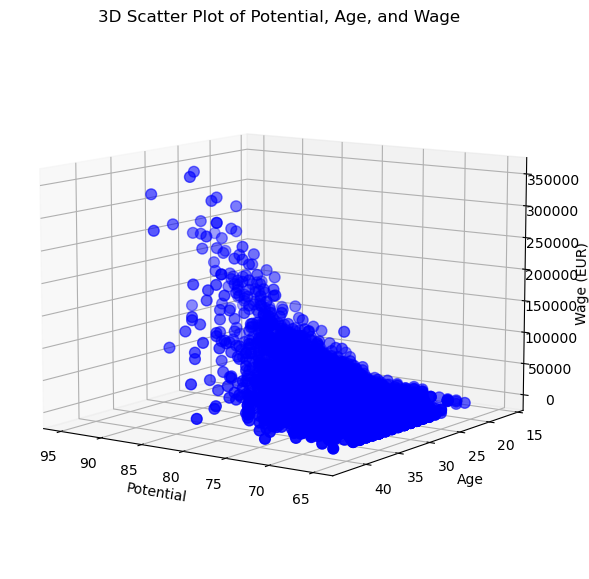

In [2]:
players_22 = pd.read_csv("players_22.csv")
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(players_22['potential'], players_22['age'], players_22['wage_eur'], c='blue', s=60)
ax.set_xlabel('Potential')
ax.set_ylabel('Age')
ax.set_zlabel('Wage (EUR)')
ax.set_title('3D Scatter Plot of Potential, Age, and Wage')


elev = 10  # elevation angle
azim = 125  # azimuth angle
ax.view_init(elev=elev, azim=azim)

plt.show()

### 2D Scatter Plot of Age and Value

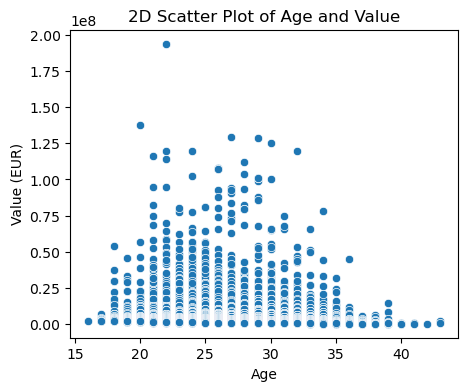

In [3]:
plt.figure(figsize=(5,4))
sns.scatterplot(x='age', y='value_eur', data=players_22)
plt.title('2D Scatter Plot of Age and Value')
plt.xlabel('Age')
plt.ylabel('Value (EUR)')
plt.show()

### 2D Scatter Plot of Potential and Value

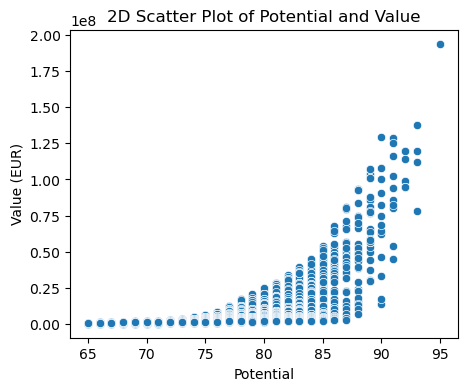

In [4]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x='potential', y='value_eur', data=players_22)
plt.title('2D Scatter Plot of Potential and Value')
plt.xlabel('Potential')
plt.ylabel('Value (EUR)')
plt.show()

# Custom K-means Algorithm

This the custom implementation for kmeans algorithm. <br>
In the fit method we d the following: <br>
- Initialize cluster centroids randomly from the data points.
- Iteratively perform the K-Means algorithm until convergence or the maximum number of iterations is reached. Convergence is determined by checking if the centroids have not changed from the previous iteration.
- Within each iteration, it updates the cluster assignaments (labels) based on the current centroids, then calculates new centroids based on the current assignments.

In the predict method, we assign data points to the nearest centroid based on the current state of the centroids.

In [5]:
class Custom_KMeans:
    def __init__(self, k=5, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels = None

    def fit(self, data):
        self.centroids = self.random_centroids(data)
        self.labels = self.get_labels(data, self.centroids)
        old_centroids = pd.DataFrame()
        iteration = 1

        while iteration <= self.max_iterations and not self.centroids.equals(old_centroids):
            old_centroids = self.centroids
            self.labels = self.get_labels(data, self.centroids)
            self.centroids = self.new_centroids(data, self.labels)
            self.plot_clusters(data, iteration)  # Plot clusters in each iteration
            iteration += 1

    def predict(self, data):
        return self.get_labels(data, self.centroids)

    def random_centroids(self, data):
        np.random.seed(42)
        random_indices = np.random.choice(data.index, size=self.k, replace=False)
        centroids = data.loc[random_indices].transpose()
        return centroids

    def get_labels(self, data, centroids):
        distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
        return distances.idxmin(axis=1)

    def new_centroids(self, data, labels):
        return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

    def plot_clusters(self, data, iteration):
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(data)
        centroids_2d = pca.transform(self.centroids.T)
        clear_output(wait=True)
        plt.title(f'Iteration {iteration}')
        plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=self.labels)
        plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1])
        plt.show()

## Load the dataset and do scaling

In [6]:
# Dataset
players = pd.read_csv("players_22.csv")
features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)
data = players[features].copy()

# Min-max scaling # data in the range [0-10]
data = (data - data.min()) / (data.max() - data.min()) * 9 + 1

## Fit and Predict using Custom K-means Algorithn

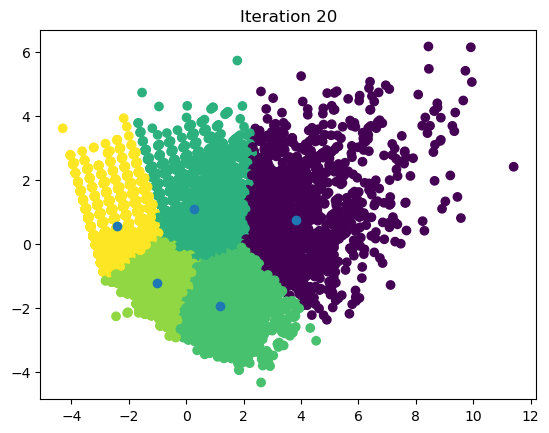

,305,2644,2901,3347,3959
overall,5.438062,3.609962,2.307987,1.667937,1.647690
potential,6.111958,3.579351,4.931876,2.807884,1.654549
wage_eur,2.210879,1.396542,1.226280,1.113935,1.097364
value_eur,1.944750,1.142334,1.147940,1.065168,1.034877
age,4.189694,5.490066,2.881177,3.813169,5.751287


In [7]:
# Create KMeans object
kmeans = Custom_KMeans(k=5, max_iterations=100)

# Fit the data
kmeans.fit(data)

# Get labels for prediction
custom_labels = kmeans.predict(data)

centroids = kmeans.centroids
centroids

#The visualization of the iterations will appear.

## Run K-means from Scikit-Learn

In [8]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)

kmeans.fit(data)
sklearn_labels = kmeans.predict(data)
transposed_cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=features).T

transposed_cluster_centers_df

,0,1,2,3,4
overall,1.732154,3.125516,6.084768,3.736294,1.852639
potential,1.763777,5.460809,6.407952,3.653629,3.342568
wage_eur,1.103437,1.385717,2.825003,1.450100,1.132157
value_eur,1.036697,1.253634,2.376346,1.157625,1.077253
age,5.678956,3.020039,4.711245,5.669400,3.609094


# Calculate the silhouette score to compare custom to scikit-learn implementation

In [9]:
# Calculate the silhouette score for the custom KMeans clustering
silhouette_custom = silhouette_score(data, custom_labels)
print(f"Silhouette Score for Custom KMeans: {silhouette_custom:.3f}")

# Calculate the silhouette score for scikit-learn's KMeans clustering
silhouette_sklearn = silhouette_score(data, sklearn_labels)
print(f"Silhouette Score for Scikit-learn KMeans: {silhouette_sklearn:.3f}")

Silhouette Score for Custom KMeans: 0.328
Silhouette Score for Scikit-learn KMeans: 0.348
